# Downloading the Dataset

In [1]:
#!wget https://myblog-imgs.s3.amazonaws.com/project/dataset.zip

In [2]:
#!unzip dataset.zip

# Importing Modules

Importing all the modules which we are going to use for this problem.

In [22]:
import torch
import numpy as np
import random
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
import operator
import matplotlib.pyplot as plt

from torchvision.transforms import Compose, ToTensor, Resize
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader,Dataset
from torchsummary import summary
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import Image as IPImage


# Function to split the dataset into test and train

This function is used to create the test and training split of the dataset. 


In [19]:
def train_val_dataset(dataset, val_split=0.20):
    '''
    input: takes an torchvision.datasets.ImageFolder object
    return: a dict with "test" and "train" key, with the split of data, w.r.t split ratio(test_size)
    '''
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['test'] = Subset(dataset, val_idx)
    
    return datasets

# Some helper functions to print the image

In [20]:
def imshow(img,text=None,should_save=False):
    '''
    This function takes an Image and prints the image. 
    '''
    npimg = img.numpy()
    plt.figure(figsize=(20,20))
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# Dataset Class 
## Triplet Pair -> {`Anchor`, `Positive` and `Negative`}

Dataset generates a pair of images. 
    - With label of 0 for positive pair(sketch and photo are same) 
    - With lebel of 1 for imposter pair(sketch and photo are different) 

In [23]:
IPImage(url='https://myblog-imgs.s3.amazonaws.com/project/match_mismatch.png')

In [24]:
class SNDataset(Dataset):
    '''
    This class is used to generate an image tuple as a generator, which will randomly generate 
    a pair of (Image, Sketch, Match/Mismatch)
    '''
    def __init__(self,photoFolderDataset, sketchFolderDataset, 
                 photoFolderIndex, sketchFolderIndex,
                 transform=None, should_invert=False):
        
        self.photoFolderDataset = photoFolderDataset   
        self.sketchFolderDataset = sketchFolderDataset
        
        self.photoFolderIndex = photoFolderIndex
        self.sketchFolderIndex = sketchFolderIndex
        
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        '''
        This generator helps to randomly pick a pair of `Sketch and `Image`, which may be of same same 
        class or different class. Since we need to make sure, this generates, pair with roughly 
        same probability, with around 50% of the images of same class and rest of the other class.
        '''
        
        # Randomly picking the 1st sketch from the sketch dataset 
        img0_tuple = random.choice(self.sketchFolderDataset.imgs) 

        # This kind of assures we have roughly equal propability of the same and different class
        should_get_same_class = random.randint(0,1) 
        
        if should_get_same_class:
            while True:
                #  Looping till it gets the same class image is found
                img1_tuple = random.choice(self.photoFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                # Looping till it gets some different class image is found
                img1_tuple = random.choice(self.photoFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Returning the pair of (image, sketch, label) with a label indicating if its a match or mismatch
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return sum([len(self.photoFolderDataset.imgs), len(self.sketchFolderDataset.imgs)])

# Creating the DataLoader for TRAINING
Loading the data set for both photo and sketch, and split for test and training# Creating the DataLoader for TRAINING

### Dataset Path

In [25]:
# Path for the Photo and Sketch 

photo_main_dir = "dataset/photo"
sketch_main_dir = "dataset/sketch"

### For Photo
Spliting the Photo dataset into test and train

In [26]:
dataset_p = ImageFolder(photo_main_dir)

dataset_photo = train_val_dataset(dataset_p)
dataset_photo_train_idx = dataset_photo['train'].indices    # Indices of photos for training from the dataset_p
dataset_photo_test_idx = dataset_photo['test'].indices      # Indices of photos for testing from the dataset_p

### For Sketch
Spliting the Sketch dataset into test and train

In [27]:
dataset_s = ImageFolder(sketch_main_dir)

dataset_sketch = train_val_dataset(dataset_s)
dataset_sketch_train_idx = dataset_sketch['train'].indices  # Indices of sketchs for training from the dataset_s
dataset_sketch_test_idx = dataset_sketch['test'].indices    # Indices of sketchs for testing from the dataset_s

### Creating the `SNDataset` object instance

In [28]:
mydataset = SNDataset(photoFolderDataset=dataset_p,
                      sketchFolderDataset=dataset_s,
                      photoFolderIndex=dataset_photo_train_idx,
                      sketchFolderIndex=dataset_sketch_train_idx,
                      transform=transforms.Compose([transforms.Resize((100,100)),
                                                    transforms.ToTensor()
                                                   ]),
                     )

# Some sample to view the Images 


Creating the `DataLoader` with the custom `SNDataset` object

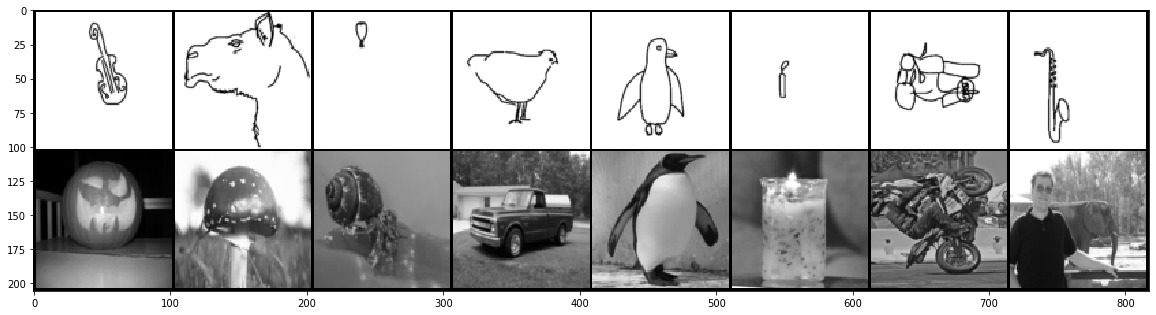

Class of the above pair of images, 0 indicates MATCH, 1 indicates MISMATCH

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [31]:
my_dataloader = DataLoader(mydataset,
                           shuffle=True,
                           num_workers=8,
                           batch_size=8)
dataiter = iter(my_dataloader)

one_batch = next(dataiter)
concatenated = torch.cat((one_batch[0],one_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print("Class of the above pair of images, 0 indicates MATCH, 1 indicates MISMATCH\n")
print(one_batch[2].numpy())

# CNN Definition (Siamese Network)
Defining the CNN for the `Siamese Network`

In [32]:
IPImage(url='https://myblog-imgs.s3.amazonaws.com/project/cnn_network.png')

In [33]:
class SN(nn.Module):
    '''
    Network used is a simple CNN, with:
    Conv2d-> ReLU -> BatchNorm2d -> Conv2d -> ReLU -> BatchNorm2d -> Conv2d -> ReLU -> BatchNorm2d

    Followed by a fully connected layer:
    Linear -> ReLU -> Linear -> ReLU -> Linear
    '''
    def __init__(self):
        super(SN, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Contrastive Loss

In [34]:
class CLoss(torch.nn.Module):
    '''
    Since, we are using Siamese Architecture and we are not classifying the input images, 
    but to needed a mechanism to differentiate between them. So, instead of using any classification 
    loss function, this architecture is better suited to use a contrastive function. 
    And in a nutshell this function simply evaluates how well the network is able to distinguish 
    a given pair of images.
    '''
    def __init__(self, margin=2.0):
        super(CLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

# Loading the Model

Training is performed in the other notebook : `Sketchy_Training.ipynb`

In [35]:
# Load the model 
PATH = "entire_model.pt"
net = torch.load(PATH)
net.eval()

criterion = CLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

# Testing(Inference)

In [36]:
def imshow_inference(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    


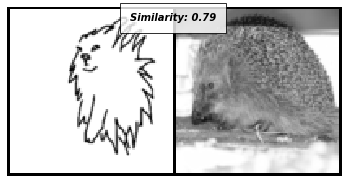

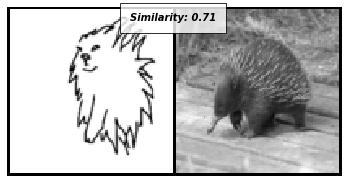

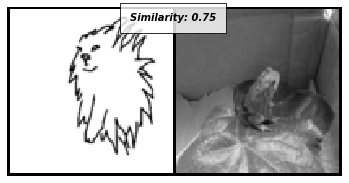

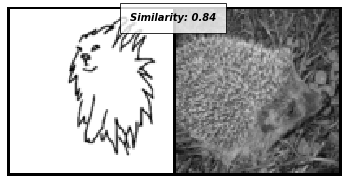

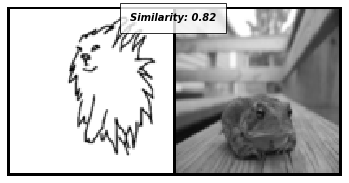

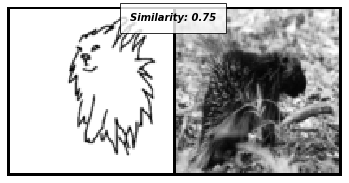

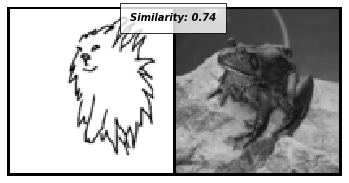

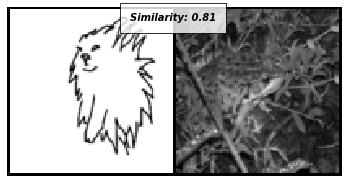

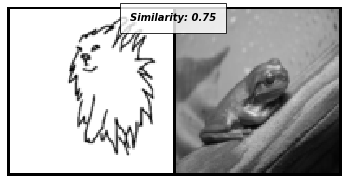

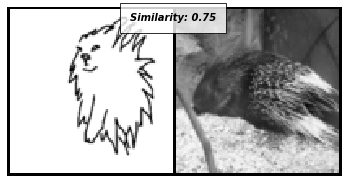

In [39]:
siamese_dataset = SNDataset(photoFolderDataset=dataset_p,
                                        sketchFolderDataset=dataset_s,
                                        photoFolderIndex=dataset_photo_test_idx,
                                        sketchFolderIndex=dataset_sketch_test_idx,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)


test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)

counter = 0
for i in range(len(dataset_photo_train_idx)):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    if euclidean_distance.item() < .3:
        imshow_inference(torchvision.utils.make_grid(concatenated),'Similarity: {:.2f}'.format(1-euclidean_distance.item()))
        counter += 1
    if counter >= 10:
        break

